In [58]:
import graphviz as gp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

url = "C:\\Users\\Hao\\Desktop\\ML Stuffs\\phishing_final.csv"

# DATA PROCESSING

In [33]:
phishing_table = pd.read_csv(url) #Read data

In [34]:
#Handling missing data
for i in phishing_table.columns:
    if i == 'Result':
        break
    most_freq = phishing_table[i].mode().values[0]
    phishing_table[i].fillna(value = most_freq, inplace=True)
phishing_table = phishing_table.dropna()

In [35]:
#Encode categorical values
enc = preprocessing.OrdinalEncoder(dtype= np.int8)
enc.fit(phishing_table)

phishingEncode = enc.transform(phishing_table)

phishing = pd.DataFrame(phishingEncode, columns=phishing_table.columns)

In [36]:
#Target and Attribute splitting
phishingResult = phishing[['Result']]
phishingData = phishing.drop(columns ='Result')

phishingDataReduced = phishing[['web_traffic', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor']]

In [37]:
#Split data for train-test
#Normal data
#trainX, testX, trainY, testY = train_test_split(phishingData, phishingResult, test_size=0.25)

#Reduced Data
trainX, testX, trainY, testY = train_test_split(phishingDataReduced, phishingResult, test_size=0.25)

# Normal Decision Tree Classifier

In [38]:
#Decision Tree Classifier
clf = tree.DecisionTreeClassifier(max_features='sqrt',max_depth=8,criterion="gini")
clf.fit(trainX, trainY)
predict = clf.predict(testX)

print(metrics.classification_report(testY, predict))

print(metrics.accuracy_score(testY, predict))
print(metrics.precision_score(testY, predict))
print(metrics.confusion_matrix(testY, predict))

print("node count:", clf.tree_.node_count)

#Graphviz... since it sometimes has problems... I'll just get the previously worked ones...
#dot_data = tree.export_graphviz(clf, out_file= None, feature_names=phishingDataReduced.columns, class_names=['Phish', 'Not Phish'], filled=True, rounded=False, special_characters=True)
#graph = gp.Source(dot_data)
#graph

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1108
           1       0.82      0.94      0.88      1393

   micro avg       0.85      0.85      0.85      2501
   macro avg       0.87      0.84      0.85      2501
weighted avg       0.86      0.85      0.85      2501

0.854858056777
0.824307304786
[[ 829  279]
 [  84 1309]]
('node count:', 57L)


In [10]:
#Parameters tuning --- ONLY RUN WHEN NEED TO RE-TUNE PARAMETERS
parameters_normal = [{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
                      'max_features': ['sqrt', 'log2'], 'criterion' :['gini', 'entropy']}]

grid_search_normal = GridSearchCV(tree.DecisionTreeClassifier(), parameters_normal, cv=10, n_jobs=-1)
grid_search_normal.fit(trainX, trainY)

print("Best Accurancy =" +str( grid_search_normal.best_score_))
print("best parameters =" + str(grid_search_normal.best_params_)) 

Best Accurancy =0.8632
best parameters ={'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 8}


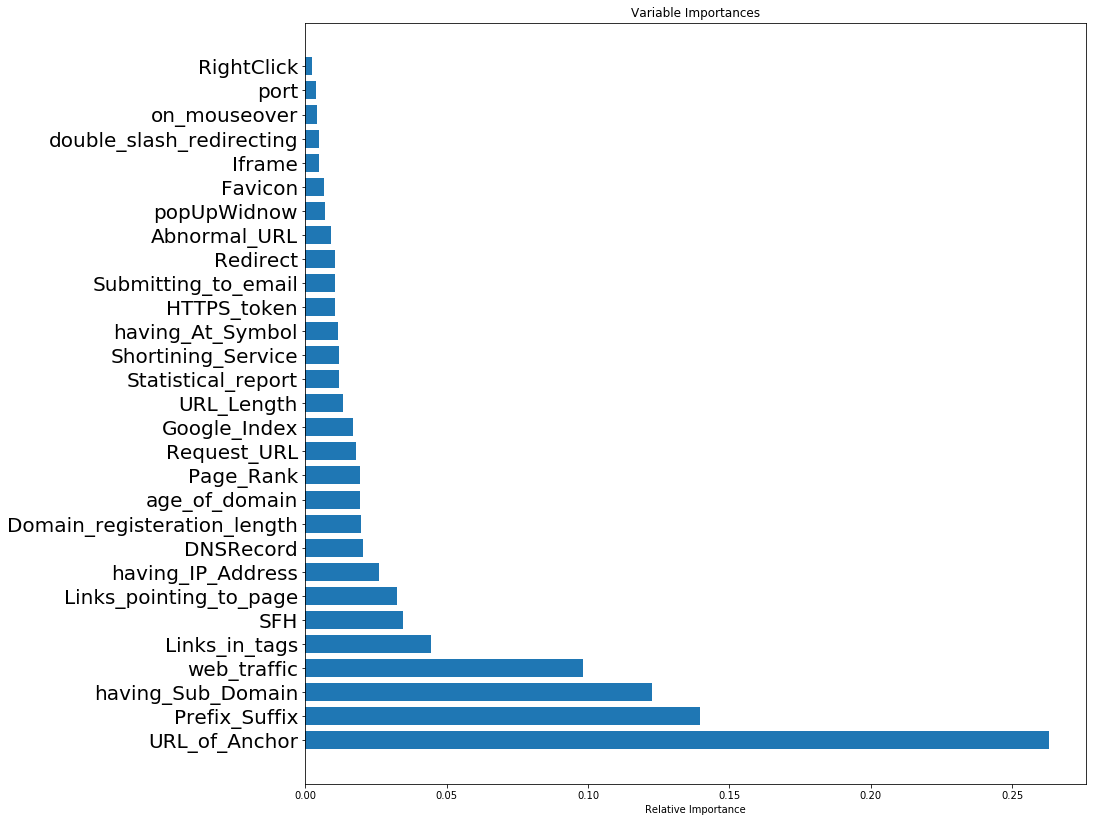

In [103]:
#This section is a supporting section. Its purpose is to find out significant contributors to the decision tree.
#This is meant to be used with the ORIGINAL PROCESSED DATA, not the REDUCED DATA

#importances = clf.feature_importances_
#names = phishingData.columns
#sort_importances = sorted(importances, reverse=True)
#indices = np.argsort(-importances)
#var_imp = pd.DataFrame(sort_importances, names[indices], columns=['importance'])

#plt.figure(figsize=(14,14))
#plt.title("Variable Importances")
#plt.barh(np.arange(len(names)), sort_importances, height = 0.75)
#plt.yticks(np.arange(len(names)), names[indices], fontsize=20)
#plt.xlabel('Relative Importance')
#plt.show()

#significant contributors: 'web_traffic', 'having_Sub_Domain', 'Prefix_Suffix', 'URL_of_Anchor'

In [44]:
#KFold normal decision tree- 10 splits, accuracy is the average of all splits' accuracies
result = []
kf = KFold(n_splits=10)
for trainIndex, testIndex in kf.split(phishingData):
    kf_trainX, kf_testX, kf_trainY, kf_testY = train_test_split(np.array(phishingDataReduced.loc[trainIndex]), np.array(phishingResult.loc[trainIndex]), test_size=0.20)
    clf.fit(kf_trainX, kf_trainY)
    kf_predict = clf.predict(kf_testX)

    result.append(metrics.accuracy_score(kf_testY, kf_predict))

np.mean(result)

0.85879233759022766

# Random Forest Classifier

In [25]:
#DO NOT RUN THIS CODE BLOCK AGAIN UNLESS YOU NEED TO RE-TUNE PARAMETERS
#Parameter tuning to find best parameters for random forest classifier

parameters = [{'n_estimators': [100, 200, 300, 400, 500, 600, 700], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
               'max_features': ['sqrt', 'log2'], 'criterion' :['gini', 'entropy']}]

search_rf = GridSearchCV(RandomForestClassifier(),  parameters,cv =10, n_jobs= -1)
search_rf.fit(trainX, trainY)

print("Best Accuracy =" +str( search_rf.best_score_))
print("best parameters =" + str(search_rf.best_params_)) 

#Best parameters: 'max_features': 'sqrt', 'n_estimators': 300, 'criterion': 'gini', 'max_depth':13

C:\Users\Hao\Anaconda2\envs\Working\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Accurancy =0.865066666667
best parameters ={'max_features': 'sqrt', 'n_estimators': 400, 'criterion': 'gini', 'max_depth': 7}


In [39]:
#Random forest classifier
rf_classifier = RandomForestClassifier(max_features= 'sqrt', n_estimators= 400, criterion= 'gini', max_depth= 7,  random_state = 0)
rf_classifier.fit(trainX, trainY)

#predicting the tests set result
rf_predict = rf_classifier.predict(testX)

print(metrics.accuracy_score(testY, rf_predict))
print(metrics.precision_score(testY, rf_predict))
print(metrics.confusion_matrix(testY, rf_predict))

#Random forest averages the decision trees

C:\Users\Hao\Anaconda2\envs\Working\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.854858056777
0.824307304786
[[ 829  279]
 [  84 1309]]


In [46]:
#KFold random forest - 10 splits, final accuracy is the average of all splits' accuracies
result_rf=[]
for trainIndex, testIndex in kf.split(phishingDataReduced):
    kf_trainX, kf_testX, kf_trainY, kf_testY = train_test_split(np.array(phishingDataReduced.loc[trainIndex]), np.array(phishingResult.loc[trainIndex]), test_size=0.20)
    rf_classifier.fit(kf_trainX, kf_trainY)
    kf_predict = rf_classifier.predict(kf_testX)

    result_rf.append(metrics.accuracy_score(kf_testY, kf_predict))

np.mean(result_rf)

C:\Users\Hao\Anaconda2\envs\Working\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.86045878832747247

# AdaBoost Classifier

In [62]:
params_ada = [{'n_estimators': [300, 400, 500, 600, 700], 'learning_rate': [0.1, 0.2, 0.5, 1]}]
search_ada = GridSearchCV(AdaBoostClassifier(), params_ada, cv = 10, n_jobs= -1)
search_ada.fit(trainX, trainY)

print("Best Accuracy =" +str( search_ada.best_score_))
print("best parameters =" + str(search_ada.best_params_)) 

Best Accuracy =0.864666666667
best parameters ={'n_estimators': 300, 'learning_rate': 0.1}


In [70]:
ada = AdaBoostClassifier(n_estimators=300, learning_rate=0.1)
ada.fit(trainX, trainY)

ada_predict = ada.predict(testX)

print(metrics.accuracy_score(testY, ada_predict))
print(metrics.precision_score(testY, ada_predict))
print(metrics.confusion_matrix(testY, ada_predict))

print (metrics.classification_report(testY, ada_predict))

0.854058376649
0.820848938826
[[ 821  287]
 [  78 1315]]
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1108
           1       0.82      0.94      0.88      1393

   micro avg       0.85      0.85      0.85      2501
   macro avg       0.87      0.84      0.85      2501
weighted avg       0.86      0.85      0.85      2501



In [50]:
#KFold Adaboost - 10 splits, final accuracy is the average of all splits' accuracies
result_ada=[]
for trainIndex, testIndex in kf.split(phishingDataReduced):
    ada_trainX, ada_testX, ada_trainY, ada_testY = train_test_split(np.array(phishingDataReduced.loc[trainIndex]), np.array(phishingResult.loc[trainIndex]), test_size=0.20)
    ada.fit(ada_trainX, ada_trainY)
    ada_predict = ada.predict(ada_testX)

    result_ada.append(metrics.accuracy_score(ada_testY, ada_predict))

np.mean(result_ada)

0.86212459127645125

# Bagging Classifier

In [74]:
#Parameter turning for Bagging
params_bag = [{'n_estimators': [100, 200, 300, 400, 500, 600, 700]}]
search_bag = GridSearchCV(BaggingClassifier(), params_bag, cv = 10, n_jobs= -1)
search_bag.fit(trainX, trainY)

print("Best Accuracy =" +str( search_bag.best_score_))
print("best parameters =" + str(search_bag.best_params_)) 

Best Accuracy =0.864666666667
best parameters ={'n_estimators': 100}


In [75]:
bag = BaggingClassifier(n_estimators=100)
bag.fit(trainX, trainY)

bag_predict = bag.predict(testX)

print(metrics.accuracy_score(testY, bag_predict))
print(metrics.precision_score(testY, bag_predict))
print(metrics.confusion_matrix(testY, bag_predict))

print (metrics.classification_report(testY, bag_predict))

#Since bagging classifier's result is very similar to random forest and normal decision tree, further inspection is not needed.

0.854858056777
0.824307304786
[[ 829  279]
 [  84 1309]]
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1108
           1       0.82      0.94      0.88      1393

   micro avg       0.85      0.85      0.85      2501
   macro avg       0.87      0.84      0.85      2501
weighted avg       0.86      0.85      0.85      2501

